In [1]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

caltech_dir = "./train"
categories = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
nb_classes = len(categories)

image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.bmp")
    print(cat, " 파일 개수 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
            print(cat, " : ", f)

X = np.array(X)
y = np.array(y)
#1 0 0 0 이면 airplanes
#0 1 0 0 이면 buddha 이런식


X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("./train/multi_image_data.npy", xy)

print("ok", len(y))

D:\ProgramData\Anaconda3\envs\deep\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
D:\ProgramData\Anaconda3\envs\deep\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
D:\ProgramData\Anaconda3\envs\deep\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


1  파일 개수 :  106
1  :  ./train/1\P_10063.bmp
2  파일 개수 :  439
2  :  ./train/2\P_1000.bmp
3  파일 개수 :  3673
3  :  ./train/3\P_10.bmp
3  :  ./train/3\P_2054.bmp
3  :  ./train/3\P_564.bmp
3  :  ./train/3\P_6942.bmp
3  :  ./train/3\P_8300.bmp
3  :  ./train/3\P_9660.bmp
4  파일 개수 :  2392
4  :  ./train/4\P_10001.bmp
4  :  ./train/4\P_2805.bmp
4  :  ./train/4\P_5503.bmp
4  :  ./train/4\P_87.bmp
5  파일 개수 :  3726
5  :  ./train/5\P_10000.bmp
5  :  ./train/5\P_1849.bmp
5  :  ./train/5\P_3139.bmp
5  :  ./train/5\P_4437.bmp
5  :  ./train/5\P_6524.bmp
5  :  ./train/5\P_923.bmp
6  파일 개수 :  421
6  :  ./train/6\P_1.bmp
7  파일 개수 :  201
7  :  ./train/7\P_10007.bmp
8  파일 개수 :  236
8  :  ./train/8\P_1002.bmp
9  파일 개수 :  16
9  :  ./train/9\P_184.bmp
10  파일 개수 :  17
10  :  ./train/10\P_195.bmp
ok 11227


In [2]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

X_train, X_test, y_train, y_test = np.load('./train/multi_image_data.npy')
print(X_train.shape)
print(X_train.shape[0])

Using TensorFlow backend.


(8420, 64, 64, 3)
8420


In [3]:
categories = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [4]:
with K.tf.device('/GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir = './model'
    
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
model_path = model_dir + '/multi_img_classification.model'
checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15)


In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)            

In [6]:
#print("정확도 :  %.4f" % (model.evaluate(X_test,y_test)[1]))
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Train on 8420 samples, validate on 2807 samples
Epoch 1/50
8420/8420 [==============================] - 6s 692us/step - loss: 0.8144 - acc: 0.7040 - val_loss: 0.3395 - val_acc: 0.9017

Epoch 00001: val_loss improved from inf to 0.33951, saving model to ./model/multi_img_classification.model
Epoch 2/50
8420/8420 [==============================] - 5s 567us/step - loss: 0.2887 - acc: 0.8950 - val_loss: 0.1422 - val_acc: 0.9587

Epoch 00002: val_loss improved from 0.33951 to 0.14221, saving model to ./model/multi_img_classification.model
Epoch 3/50
8420/8420 [==============================] - 5s 560us/step - loss: 0.1824 - acc: 0.9385 - val_loss: 0.0985 - val_acc: 0.9697

Epoch 00003: val_loss improved from 0.14221 to 0.09846, saving model to ./model/multi_img_classification.model
Epoch 4/50
8420/8420 [==============================] - 5s 553us/step - loss: 0.1313 - acc: 0.9557 - val_loss: 0.0733 - val_acc: 0.9779

Epoch 00004: val_loss improved from 0.09846 to 0.07327, saving model to ./m

8420/8420 [==============================] - 4s 525us/step - loss: 0.0279 - acc: 0.9893 - val_loss: 0.0442 - val_acc: 0.9911

Epoch 00039: val_loss did not improve from 0.03715
Epoch 40/50
8420/8420 [==============================] - 4s 523us/step - loss: 0.0279 - acc: 0.9893 - val_loss: 0.0475 - val_acc: 0.9922

Epoch 00040: val_loss did not improve from 0.03715
Epoch 41/50
8420/8420 [==============================] - 4s 530us/step - loss: 0.0276 - acc: 0.9897 - val_loss: 0.0494 - val_acc: 0.9914

Epoch 00041: val_loss did not improve from 0.03715
Epoch 42/50
8420/8420 [==============================] - 5s 577us/step - loss: 0.0251 - acc: 0.9924 - val_loss: 0.0491 - val_acc: 0.9914

Epoch 00042: val_loss did not improve from 0.03715
Epoch 43/50
8420/8420 [==============================] - 4s 529us/step - loss: 0.0292 - acc: 0.9898 - val_loss: 0.0536 - val_acc: 0.9904

Epoch 00043: val_loss did not improve from 0.03715


In [8]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

2807/2807 [==============================] - 1s 201us/step
정확도 : 0.9911


In [12]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

caltech_dir = "./test/3"
image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.bmp")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

X = np.array(X)
model = load_model('./model/multi_img_classification.model')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

#이 비교는 그냥 파일들이 있으면 해당 파일과 비교. 카테고리와 함께 비교해서 진행하는 것은 _4 파일.
for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    #print(i)
    #print(pre_ans)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "1"
    elif pre_ans == 1: pre_ans_str = "2"
    elif pre_ans == 2: pre_ans_str = "3"
    elif pre_ans == 3: pre_ans_str = "4"
    elif pre_ans == 4: pre_ans_str = "5"
    elif pre_ans == 5: pre_ans_str = "6"
    elif pre_ans == 6: pre_ans_str = "7"
    elif pre_ans == 7: pre_ans_str = "8"
    elif pre_ans == 8: pre_ans_str = "9"
    else: pre_ans_str = "10"
    if i[0] >= 0.8 : print(filenames[cnt].split("\\")[1]+" = "+pre_ans_str+"개")
    if i[1] >= 0.8: print(filenames[cnt].split("\\")[1]+" = "+pre_ans_str+"개")
    if i[2] >= 0.8: print(filenames[cnt].split("\\")[1]+" = "+pre_ans_str+"개")
    if i[3] >= 0.8: print(filenames[cnt].split("\\")[1]+" = "+pre_ans_str+"개")
    if i[4] >= 0.8: print(filenames[cnt].split("\\")[1]+" = "+pre_ans_str+"개")
    if i[5] >= 0.8: print(filenames[cnt].split("\\")[1]+" = "+pre_ans_str+"개")
    if i[6] >= 0.8: print(filenames[cnt].split("\\")[1]+" = "+pre_ans_str+"개")
    if i[7] >= 0.8: print(filenames[cnt].split("\\")[1]+" = "+pre_ans_str+"개")
    if i[8] >= 0.8: print(filenames[cnt].split("\\")[1]+" = "+pre_ans_str+"개")
    if i[9] >= 0.8: print(filenames[cnt].split("\\")[1]+" = "+pre_ans_str+"개")
    cnt += 1


T_100.bmp = 3개
T_101.bmp = 3개
T_1012.bmp = 3개
T_1013.bmp = 3개
T_1014.bmp = 3개
T_1015.bmp = 3개
T_1016.bmp = 3개
T_1017.bmp = 3개
T_1019.bmp = 3개
T_102.bmp = 3개
T_1020.bmp = 3개
T_1021.bmp = 3개
T_1022.bmp = 3개
T_1023.bmp = 3개
T_1024.bmp = 3개
T_1025.bmp = 3개
T_1026.bmp = 3개
T_1027.bmp = 3개
T_1028.bmp = 3개
T_103.bmp = 3개
T_1031.bmp = 3개
T_1032.bmp = 3개
T_1033.bmp = 3개
T_1034.bmp = 3개
T_1035.bmp = 3개
T_1036.bmp = 3개
T_1037.bmp = 3개
T_1038.bmp = 3개
T_1039.bmp = 3개
T_104.bmp = 3개
T_1040.bmp = 3개
T_1042.bmp = 3개
T_1045.bmp = 3개
T_105.bmp = 3개
T_106.bmp = 3개
T_1060.bmp = 3개
T_1064.bmp = 3개
T_1065.bmp = 3개
T_1066.bmp = 3개
T_1067.bmp = 3개
T_1068.bmp = 3개
T_1069.bmp = 3개
T_107.bmp = 3개
T_1070.bmp = 3개
T_1071.bmp = 3개
T_1072.bmp = 3개
T_1073.bmp = 3개
T_1075.bmp = 3개
T_108.bmp = 3개
T_109.bmp = 3개
T_1094.bmp = 3개
T_1095.bmp = 3개
T_1097.bmp = 3개
T_1098.bmp = 3개
T_1099.bmp = 3개
T_110.bmp = 3개
T_1100.bmp = 3개
T_1101.bmp = 3개
T_1102.bmp = 3개
T_1103.bmp = 3개
T_1104.bmp = 3개
T_1105.bmp = 3개
T_1106.bmp = 3개
T_1

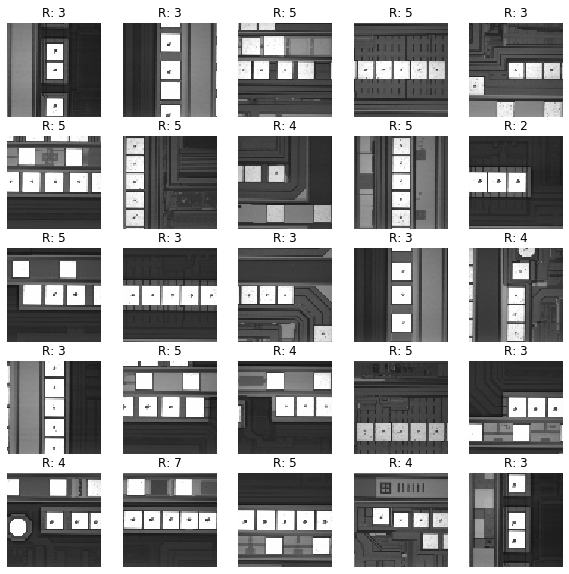

In [132]:
%matplotlib inline
import matplotlib.pyplot as plt
        
plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

for i in range(plt_row*plt_col):
    sub_plt = axarr[i//plt_row, i%plt_col]
    sub_plt.axis('off')
    sub_plt.imshow(X_test[i])
    sub_plt_title = 'R: ' + str(np.argmax(y_test[i])+1)
    sub_plt.set_title(sub_plt_title)

plt.show()